# データ拡張

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50

from modules.preprocessing import DataAugmentation
da = DataAugmentation

## データセットの生成(初回のみ実行)

In [2]:
# 1回目だけ実行
# 2回目からは不要
ref_path = '/home/workspace/dataset/org/'
ds_path = '/home/workspace/dataset/train/'
files = os.listdir(ref_path)

c_num = [1,2,3,4]
data_num = [1,2,3,4,5,6,7,8,9,10]
for _, c in enumerate(c_num):
    save_path = ds_path + 'class{}/'.format(c)
    da = DataAugmentation(save_path)
    for _, data in enumerate(data_num):
        filename = 'class{}_{}'.format(c,data)
        da.all_run(ref_path, filename, extension='.png')

## 教師データの作成

In [3]:
class_num = 4

In [23]:
def data_loder(folder_path):
    im_file_list = glob.glob(folder_path+"*.png")
    one_class = np.zeros([len(im_file_list),480,360,3])
    for i, filename in enumerate(im_file_list):
        one_class[i] = np.array(Image.open(filename).resize((480,360))).transpose(1,0,2)
    return one_class

In [24]:
x_train = np.zeros([4,600,480,360,3])
for i, c in enumerate(c_num):
    folder_path = ds_path + 'class{}/'.format(c)
    x_train[i] = data_loder(folder_path)
x_train = x_train.reshape([-1,480,360,3])

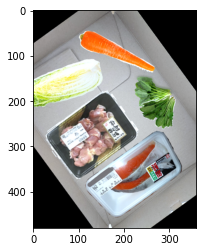

In [33]:
plt.imshow(x_train[1500].astype(np.int64))

In [34]:
y_train = np.zeros([len(x_train),class_num])
labels = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
counter = 0
for _, label in enumerate(labels):
    for j in range(len(x_train)//class_num):
        y_train[counter] = label
        counter += 1

# 献立推薦モデルの構築

## fine-tuningの準備

In [35]:
def create_model():
    # ベースモデル(ResNet)の構築
    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False
    # 出力層側に追加するレイヤーの構築
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(4, activation="softmax")
    ], name='fine_tuning')
    return model

### 構築したモデルの確認

In [36]:
model = create_model()
model.summary()

Model: "fine_tuning"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


ここで，" Non-trainable params"が0出ない理由は，バッチ正則化層の重みがtrainable=Trueになっていても初期の段階ではFalseとして扱われるからである(多分)．なので，現段階で全ての重みが学習される状態となっている．

# 献立推薦モデルの学習

In [38]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 './models/model_{epoch:03d}_{val_loss:.4f}.h5',
                 save_best_only=True
             )]

model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.2, callbacks=callbacks)

Train on 1920 samples, validate on 480 samples
Epoch 1/20
1920/1920 [==============================] - 373s 194ms/sample - loss: 0.3204 - accuracy: 0.9589 - val_loss: 0.8111 - val_accuracy: 0.5875
Epoch 2/20
1920/1920 [==============================] - 312s 162ms/sample - loss: 0.2368 - accuracy: 0.9865 - val_loss: 0.6083 - val_accuracy: 0.7500
Epoch 3/20
1920/1920 [==============================] - 312s 162ms/sample - loss: 0.1750 - accuracy: 0.9953 - val_loss: 0.2138 - val_accuracy: 0.9667
Epoch 4/20
1920/1920 [==============================] - 313s 163ms/sample - loss: 0.1405 - accuracy: 0.9958 - val_loss: 0.2123 - val_accuracy: 0.9583
Epoch 5/20
1920/1920 [==============================] - 371s 193ms/sample - loss: 0.1256 - accuracy: 0.9974 - val_loss: 0.1793 - val_accuracy: 0.9729
Epoch 6/20
1920/1920 [==============================] - 314s 163ms/sample - loss: 0.0938 - accuracy: 0.9995 - val_loss: 0.1673 - val_accuracy: 0.9729
Epoch 7/20
1920/1920 [==============================]

# 献立推薦モデルの性能評価

In [ ]:
test_loss, test_acc = trained_model.evaluate(x_test, y_test, verbose=0)